In [21]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, Model
import pathlib
from tensorflow.keras import Input
import numpy as np
from tensorflow.keras.layers import Lambda, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate, Concatenate
from tensorflow.keras.metrics import MeanIoU
import datetime
import matplotlib.pyplot as plt

In [13]:
def process_path(image_path, mask_path):
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)
    image = tf.image.decode_png(image, channels = 3)
    mask = tf.image.decode_png(mask, channels = 1)/255
    return image, mask

In [4]:
def batch_data (path_X, path_y, batch_size):
    X_names = os.listdir(path_X)
    X_path = [f'{path_X}/{file}' for file in X_names]
    y_names = os.listdir(path_y)
    y_path = [f'{path_y}/{file}' for file in y_names]
    ds_train = tf.data.Dataset.from_tensor_slices((X_path, y_path))
    return ds_train.map(process_path).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [5]:
def unet_model(img_height, img_width, channels):

    #Input
    inputs = Input((img_height, img_width, channels), name="input")
    normalisation = Lambda(lambda x: x / 255, name="normalisation")(inputs) #Normalize the pixels by dividing by 255

      
    convolution1 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(normalisation)
    convolution1 = BatchNormalization()(convolution1) 
    convolution1 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(convolution1)
    pooling1 = MaxPooling2D((2, 2))(convolution1)
    
    convolution2 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(pooling1)
    convolution2 = BatchNormalization()(convolution2)
    convolution2 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(convolution2)
    pooling2 = MaxPooling2D((2, 2))(convolution2)
     
    convolution3 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pooling2)
    convolution3 = BatchNormalization()(convolution3)
    convolution3 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(convolution3)
    pooling3 = MaxPooling2D((2, 2))(convolution3)
     
    convolution4 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pooling3)
    convolution4 = BatchNormalization()(convolution4)
    convolution4 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(convolution4)
    pooling4 = MaxPooling2D(pool_size=(2, 2))(convolution4)

    #Bottleneck at the base of the U-net 
    convolution5 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(pooling4)
    convolution5 = BatchNormalization()(convolution5)
    convolution5 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(convolution5)
    
    #Decoder where we are indicating to the model the precise location of the features 
    transconv6 = Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding='same')(convolution5)
    transconv6 = Concatenate()([transconv6, convolution4])
    convolution6 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(transconv6)
    convolution6 = BatchNormalization()(convolution6)
    convolution6 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(convolution6)
     
    transconv7 = Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding='same')(convolution6)
    transconv7 = Concatenate()([transconv7, convolution3])
    convolution7 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(transconv7)
    convolution7 = BatchNormalization()(convolution7)
    convolution7 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(convolution7)
     
    transconv8 = Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding='same')(convolution7)
    transconv8 = Concatenate()([transconv8, convolution2])
    convolution8 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(transconv8)
    convolution8 = BatchNormalization()(convolution8)
    convolution8 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(convolution8)
     
    transconv9 = Conv2DTranspose(16, kernel_size=(2, 2), strides=(2, 2), padding='same')(convolution8)
    transconv9 = Concatenate()([transconv9, convolution1])
    convolution9 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(transconv9)
    convolution9 = BatchNormalization()(convolution9)
    convolution9 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(convolution9)
  
   
    
    outputs = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(convolution9)
     
    model = Model(inputs=inputs, outputs=outputs)
    jaccard = MeanIoU(2)
    
    #loss options include: binary_crossentropy, IoU Loss (Jaccard Index), dice loss
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics="accuracy") 
    
#     model.summary()
    
    return model

In [6]:
channels=3
img_height = 256
img_width = 256

In [7]:
model = unet_model(img_height, img_width, channels)

2022-12-01 14:30:24.047101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-01 14:30:24.074355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-01 14:30:24.075053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-01 14:30:24.075819: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [8]:
path_X = '/home/zhlj/code/solar_panel_segmentation/tests/Small_dataset/Images'
path_y = '/home/zhlj/code/solar_panel_segmentation/tests/Small_dataset/Target'
batch_size = 8

In [213]:
# log data for tensorboard visualization
logs_dir = log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_dir , histogram_freq=1)

In [214]:
batches = batch_data(path_X,path_y,batch_size)

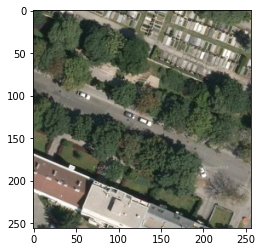

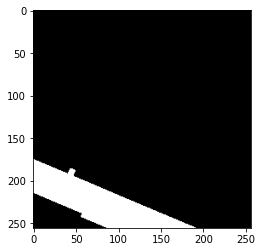

In [188]:
for image, mask in batches:
    plt.imshow(image[0])
    plt.show()
    plt.imshow(mask[0], cmap='gray')
    break

In [215]:
history = model.fit(batches, epochs=100, callbacks=[tb_callback])

Epoch 1/100
276/276 [==============================] - 43s 155ms/step - loss: 1106522.7500 - accuracy: 0.1077
Epoch 2/100
276/276 [==============================] - 43s 155ms/step - loss: 1099405.7500 - accuracy: 0.1077
Epoch 3/100
143/276 [==============>...............] - ETA: 20s - loss: 1100047.0000 - accuracy: 0.1059

KeyboardInterrupt: 

In [15]:
model.layers

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 normalisation (Lambda)         (None, 256, 256, 3)  0           ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['normalisation[0][0]']          
                                )                                                                 
                                                                                              

In [26]:
output1 = model.layers[1]
output1(tf.cast(image, 'float32'))

<tf.Tensor: shape=(8, 256, 256, 3), dtype=float32, numpy=
array([[[[0.20392157, 0.27058825, 0.19607843],
         [0.19607843, 0.2627451 , 0.1882353 ],
         [0.16470589, 0.23137255, 0.15686275],
         ...,
         [0.49019608, 0.43137255, 0.34901962],
         [0.5137255 , 0.44313726, 0.35686275],
         [0.52156866, 0.43529412, 0.3529412 ]],

        [[0.19215687, 0.25882354, 0.18431373],
         [0.20392157, 0.27058825, 0.19607843],
         [0.1764706 , 0.24313726, 0.16862746],
         ...,
         [0.47058824, 0.42352942, 0.3372549 ],
         [0.48235294, 0.41960785, 0.32941177],
         [0.4862745 , 0.40392157, 0.32156864]],

        [[0.20784314, 0.27450982, 0.2       ],
         [0.24313726, 0.30980393, 0.23529412],
         [0.23137255, 0.29803923, 0.22352941],
         ...,
         [0.42352942, 0.39215687, 0.3019608 ],
         [0.4862745 , 0.4392157 , 0.34509805],
         [0.49803922, 0.43529412, 0.34509805]],

        ...,

        [[0.5803922 , 0.57254905, 

In [27]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input',
 'normalisation',
 'conv2d',
 'batch_normalization',
 'conv2d_1',
 'max_pooling2d',
 'conv2d_2',
 'batch_normalization_1',
 'conv2d_3',
 'max_pooling2d_1',
 'conv2d_4',
 'batch_normalization_2',
 'conv2d_5',
 'max_pooling2d_2',
 'conv2d_6',
 'batch_normalization_3',
 'conv2d_7',
 'max_pooling2d_3',
 'conv2d_8',
 'batch_normalization_4',
 'conv2d_9',
 'conv2d_transpose',
 'concatenate',
 'conv2d_10',
 'batch_normalization_5',
 'conv2d_11',
 'conv2d_transpose_1',
 'concatenate_1',
 'conv2d_12',
 'batch_normalization_6',
 'conv2d_13',
 'conv2d_transpose_2',
 'concatenate_2',
 'conv2d_14',
 'batch_normalization_7',
 'conv2d_15',
 'conv2d_transpose_3',
 'concatenate_3',
 'conv2d_16',
 'batch_normalization_8',
 'conv2d_17',
 'conv2d_18']

In [30]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input')>,
 <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'normalisation')>,
 <KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 128, 128, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'conv2d_4')>,
 <

In [48]:
feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)


In [32]:
feature_map_model(tf.cast(image, 'float32'))

[<tf.Tensor: shape=(8, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.20392157, 0.27058825, 0.19607843],
          [0.19607843, 0.2627451 , 0.1882353 ],
          [0.16470589, 0.23137255, 0.15686275],
          ...,
          [0.49019608, 0.43137255, 0.34901962],
          [0.5137255 , 0.44313726, 0.35686275],
          [0.52156866, 0.43529412, 0.3529412 ]],
 
         [[0.19215687, 0.25882354, 0.18431373],
          [0.20392157, 0.27058825, 0.19607843],
          [0.1764706 , 0.24313726, 0.16862746],
          ...,
          [0.47058824, 0.42352942, 0.3372549 ],
          [0.48235294, 0.41960785, 0.32941177],
          [0.4862745 , 0.40392157, 0.32156864]],
 
         [[0.20784314, 0.27450982, 0.2       ],
          [0.24313726, 0.30980393, 0.23529412],
          [0.23137255, 0.29803923, 0.22352941],
          ...,
          [0.42352942, 0.39215687, 0.3019608 ],
          [0.4862745 , 0.4392157 , 0.34509805],
          [0.49803922, 0.43529412, 0.34509805]],
 
         ...,
 
       

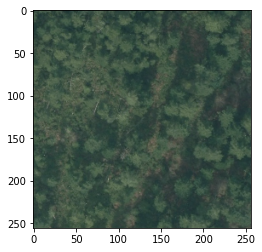

In [198]:
plt.imshow(image[1])

In [202]:
tmp_image = tf.expand_dims(image[1], axis = 0)

In [203]:
tmp_image

<tf.Tensor: shape=(1, 256, 256, 3), dtype=uint8, numpy=
array([[[[ 51,  75,  61],
         [ 50,  73,  61],
         [ 61,  85,  72],
         ...,
         [ 41,  65,  54],
         [ 40,  64,  52],
         [ 50,  73,  61]],

        [[ 49,  71,  58],
         [ 55,  77,  64],
         [ 60,  81,  70],
         ...,
         [ 40,  65,  53],
         [ 52,  76,  64],
         [ 75,  99,  87]],

        [[ 52,  73,  56],
         [ 55,  76,  62],
         [ 56,  76,  64],
         ...,
         [ 45,  69,  57],
         [ 58,  82,  70],
         [ 60,  83,  72]],

        ...,

        [[ 55,  79,  64],
         [ 57,  81,  67],
         [ 85, 109,  94],
         ...,
         [ 74,  87,  77],
         [ 70,  82,  73],
         [ 74,  85,  76]],

        [[ 75,  99,  85],
         [ 79, 102,  85],
         [ 73,  96,  79],
         ...,
         [ 75,  86,  76],
         [ 71,  81,  71],
         [ 68,  78,  67]],

        [[ 62,  86,  71],
         [ 81, 105,  89],
         [ 84, 107

In [204]:
feature_maps = feature_map_model.predict(tmp_image)

In [207]:
feature_maps[0].shape

(1, 256, 256, 3)

In [50]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")


The shape of the input is =======>> (8, 256, 256, 3)
The shape of the normalisation is =======>> (8, 256, 256, 3)
The shape of the conv2d is =======>> (8, 256, 256, 16)
The shape of the batch_normalization is =======>> (8, 256, 256, 16)
The shape of the conv2d_1 is =======>> (8, 256, 256, 16)
The shape of the max_pooling2d is =======>> (8, 128, 128, 16)
The shape of the conv2d_2 is =======>> (8, 128, 128, 32)
The shape of the batch_normalization_1 is =======>> (8, 128, 128, 32)
The shape of the conv2d_3 is =======>> (8, 128, 128, 32)
The shape of the max_pooling2d_1 is =======>> (8, 64, 64, 32)
The shape of the conv2d_4 is =======>> (8, 64, 64, 64)
The shape of the batch_normalization_2 is =======>> (8, 64, 64, 64)
The shape of the conv2d_5 is =======>> (8, 64, 64, 64)
The shape of the max_pooling2d_2 is =======>> (8, 32, 32, 64)
The shape of the conv2d_6 is =======>> (8, 32, 32, 128)
The shape of the batch_normalization_3 is =======>> (8, 32, 32, 128)
The shape of the conv2d_7 is ====

/tmp/ipykernel_915/2715591050.py:10: RuntimeWarning: invalid value encountered in subtract
  feature_image-= feature_image.mean()
/tmp/ipykernel_915/2715591050.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure( figsize=(scale * k, scale) )


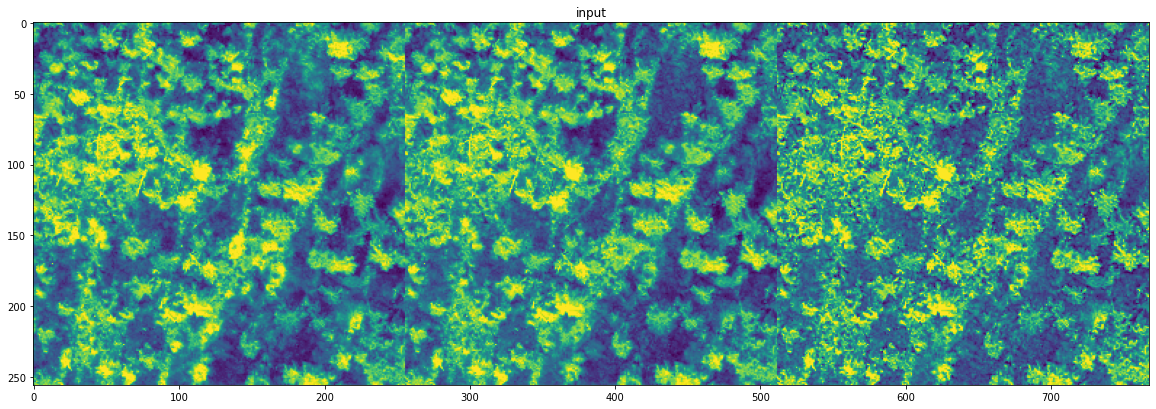

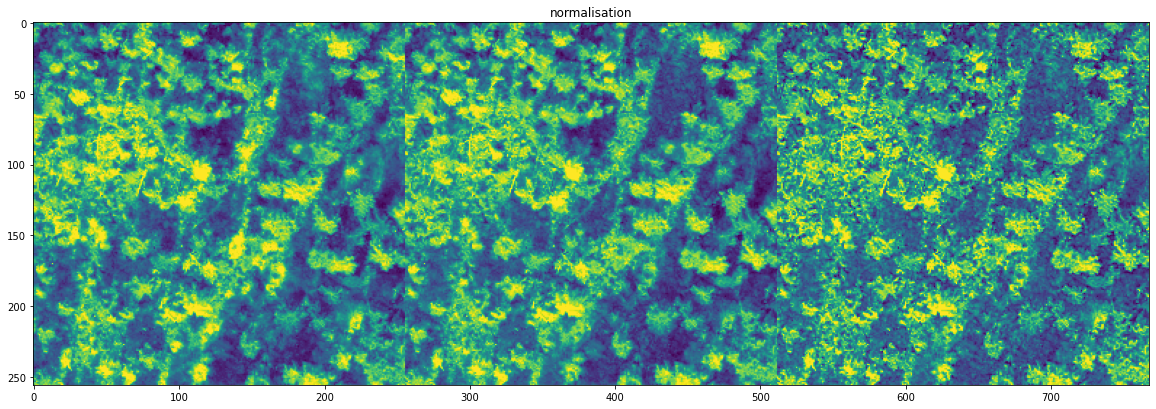

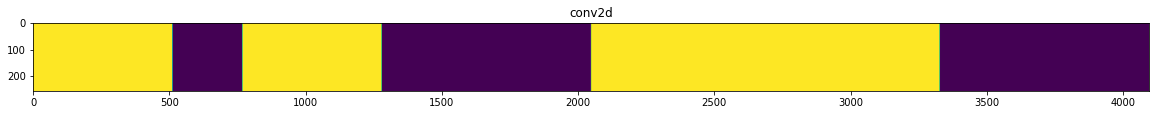

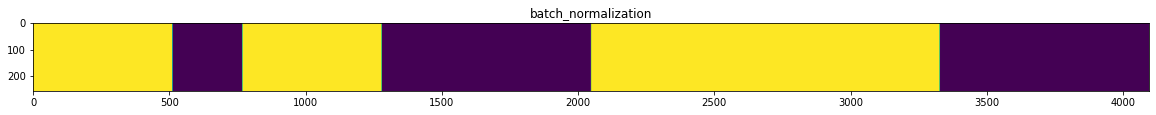

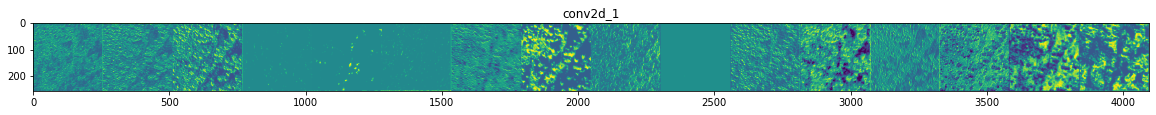

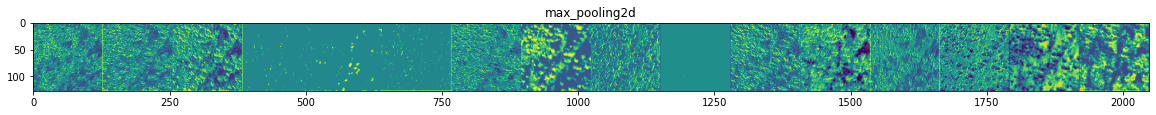

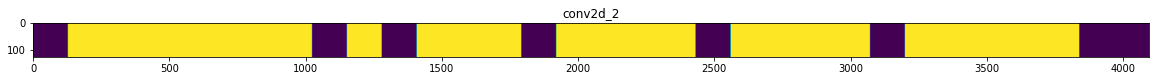

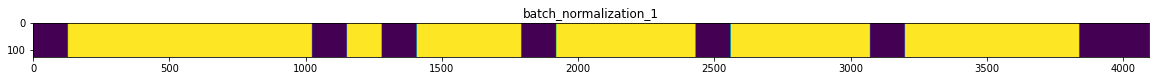

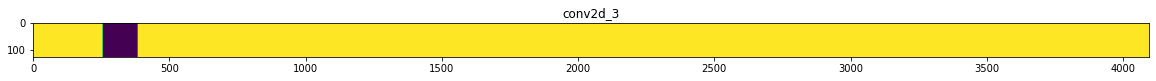

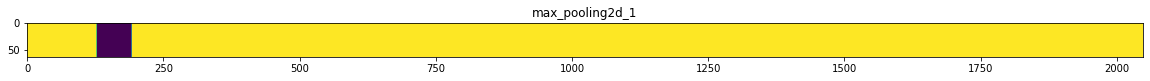

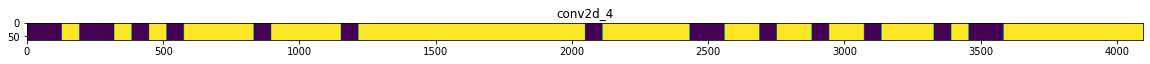

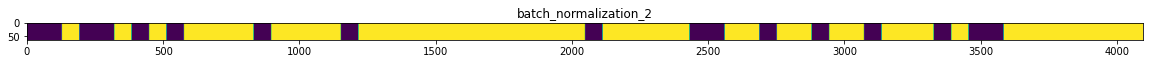

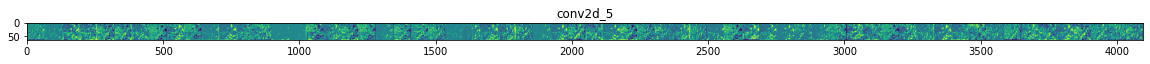

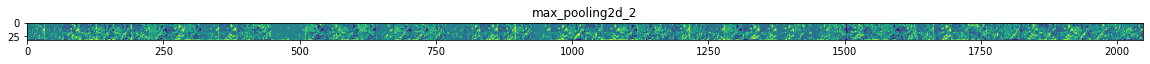

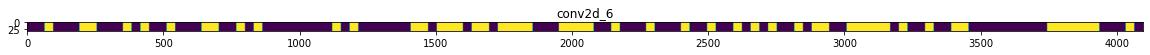

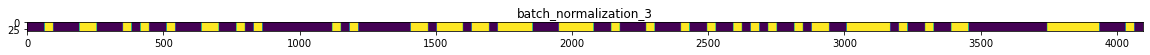

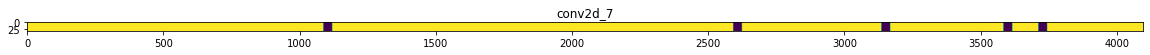

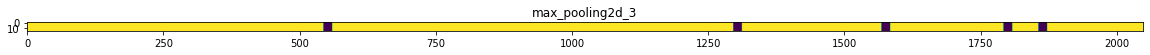

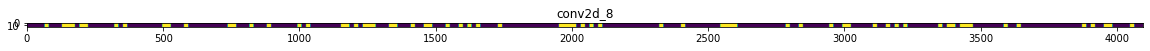

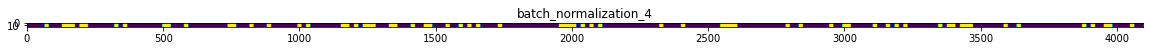

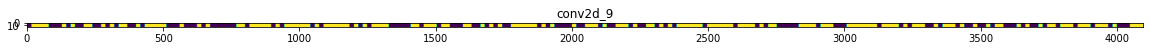

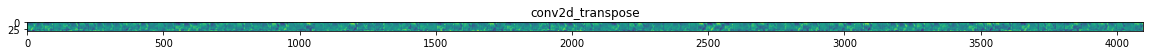

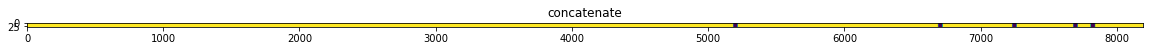

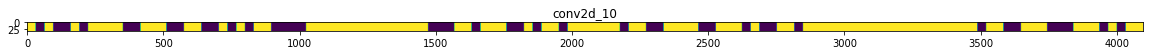

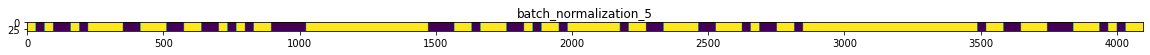

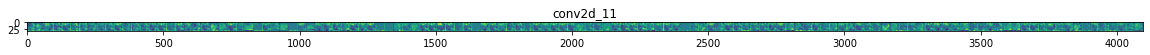

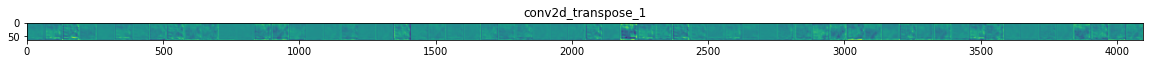

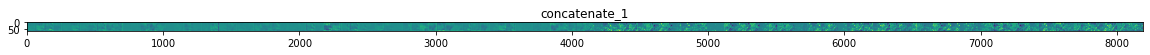

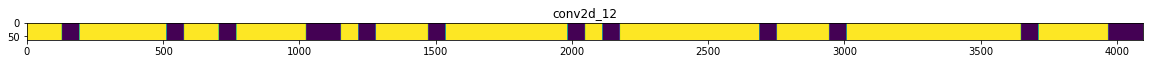

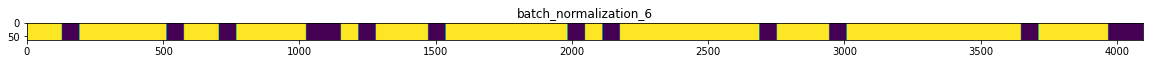

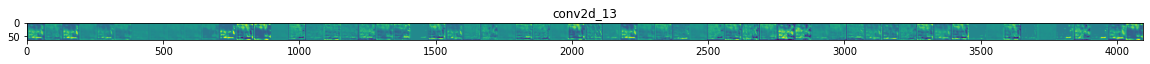

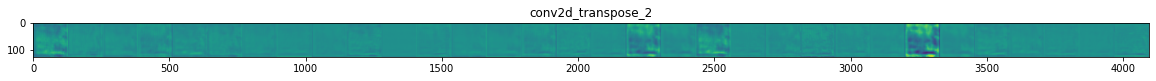

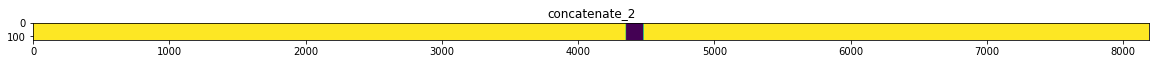

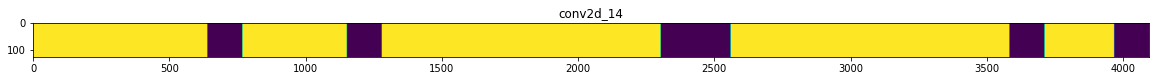

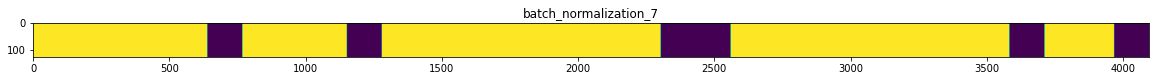

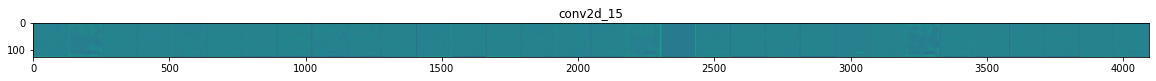

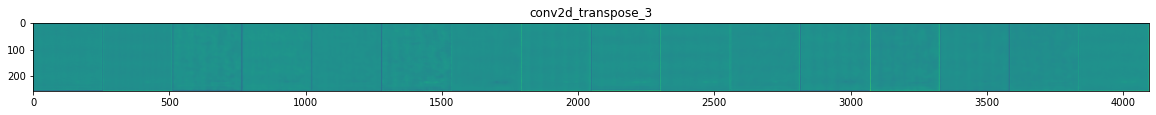

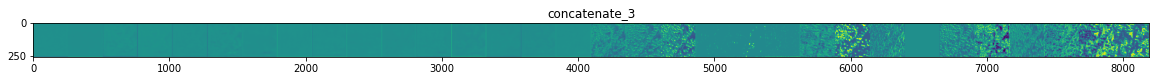

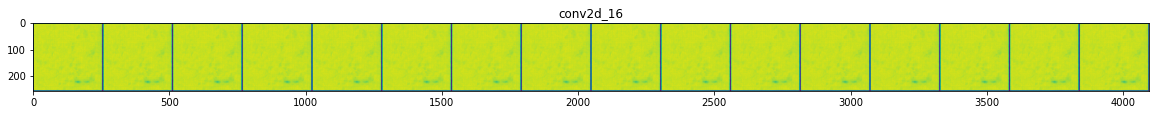

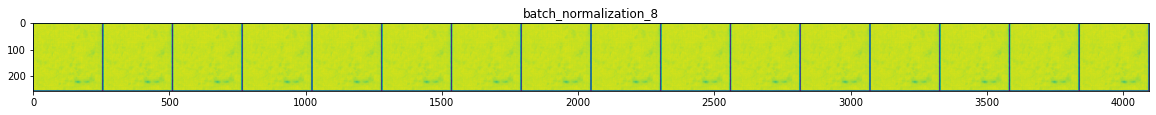

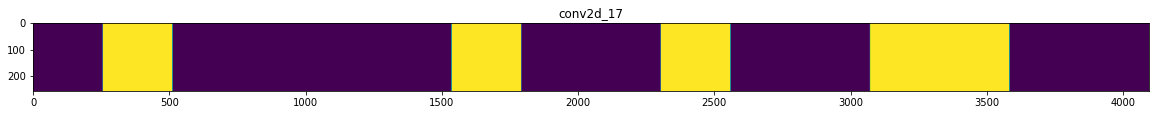

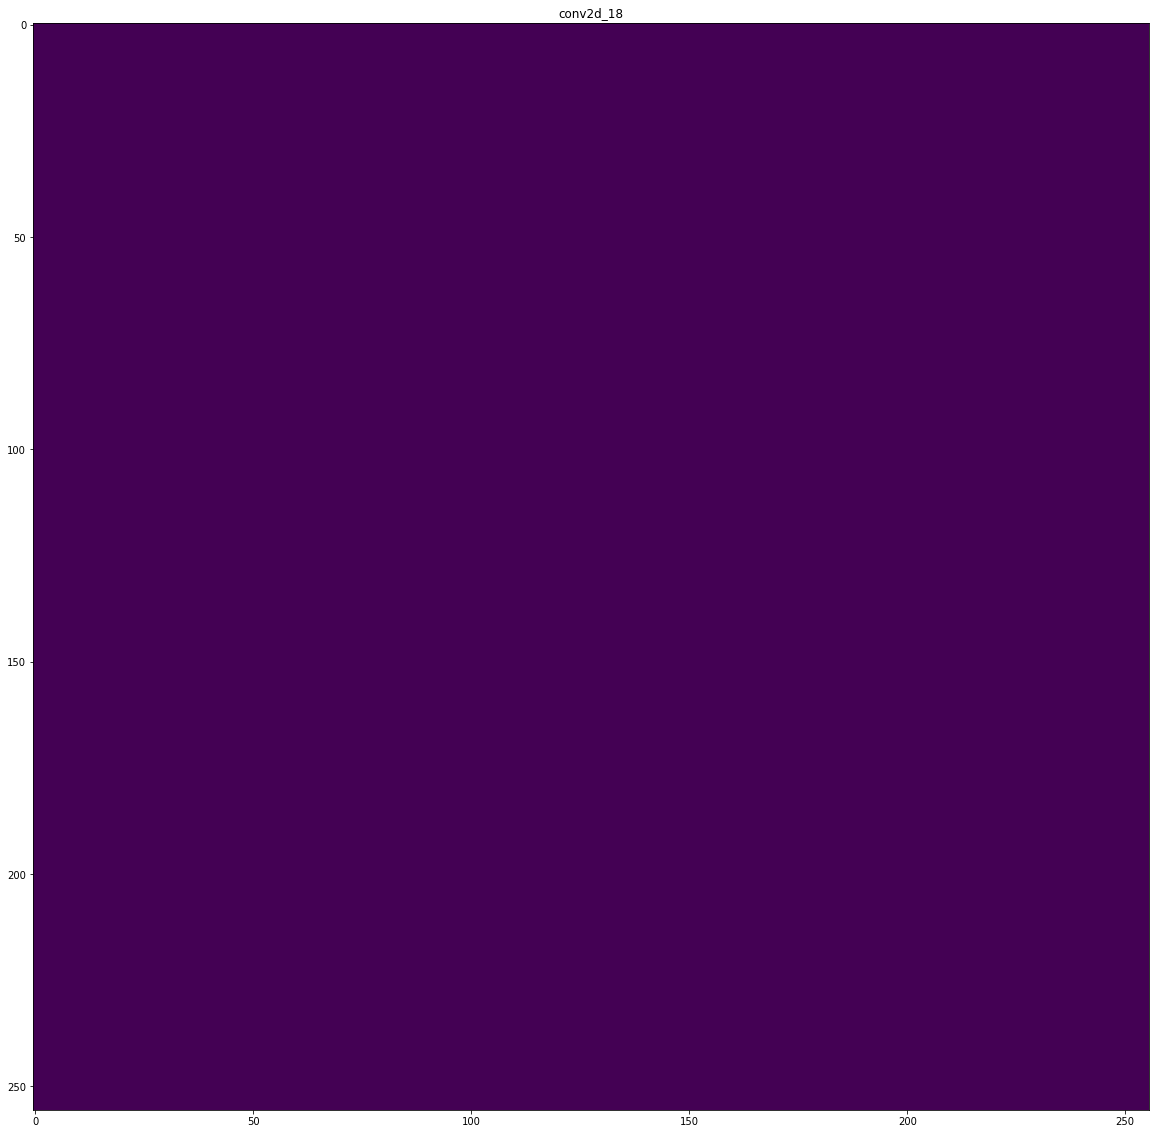

In [209]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4: # Number of feature images/dimensions in a feature map of a layer 
        k = feature_map.shape[-1]  
        size=feature_map.shape[2]
        row = feature_map.shape[1]
        
        image_belt = np.array([[0]*k*size for i in range(row)])
        for i in range(k):
            feature_image = feature_map[0, :, :, i]  #first image of the batch for channel i
            feature_image-= feature_image.mean()
            feature_image/= feature_image.std ()
            feature_image*=  64
            feature_image+= 128
            feature_image= np.clip(feature_image, 0, 255)
            image_belt[:,i * size : (i + 1) * size] = feature_image
            
        scale = 20. / k
        plt.figure( figsize=(scale * k, scale) )
        plt.title ( layer_name )
        plt.grid  (False )
        plt.imshow(image_belt, aspect='auto')
        

In [210]:
def vis_cnn_feature_maps(model, image):
    """input model and image, this function will display images after go through each CNN layer"""
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers]
    feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    image = tf.expand_dims(image, axis=0)
    feature_maps = feature_map_model.predict(image)
    for layer_name, feature_map in zip(layer_names, feature_maps):
        if len(feature_map.shape) == 4: # Number of feature images/dimensions in a feature map of a layer 
            k = feature_map.shape[-1]  
            size=feature_map.shape[2]
            row = feature_map.shape[1]

            image_belt = np.array([[0]*k*size for i in range(row)])
            for i in range(k):
                feature_image = feature_map[0, :, :, i]  #first image of the batch for channel i
                feature_image -= feature_image.mean()
                feature_image /= feature_image.std()
                feature_image *=  64
                feature_image += 128
                feature_image = np.clip(feature_image, 0, 255)
                image_belt[:,i * size : (i + 1) * size] = feature_image

            scale = 20. / k
            plt.figure( figsize=(scale * k, scale) )
            plt.title ( layer_name )
            plt.grid  (False )
            plt.imshow(image_belt, aspect='auto')


/tmp/ipykernel_915/4025018330.py:17: RuntimeWarning: invalid value encountered in divide
  feature_image /= feature_image.std()
/tmp/ipykernel_915/4025018330.py:17: RuntimeWarning: divide by zero encountered in divide
  feature_image /= feature_image.std()
/tmp/ipykernel_915/4025018330.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure( figsize=(scale * k, scale) )


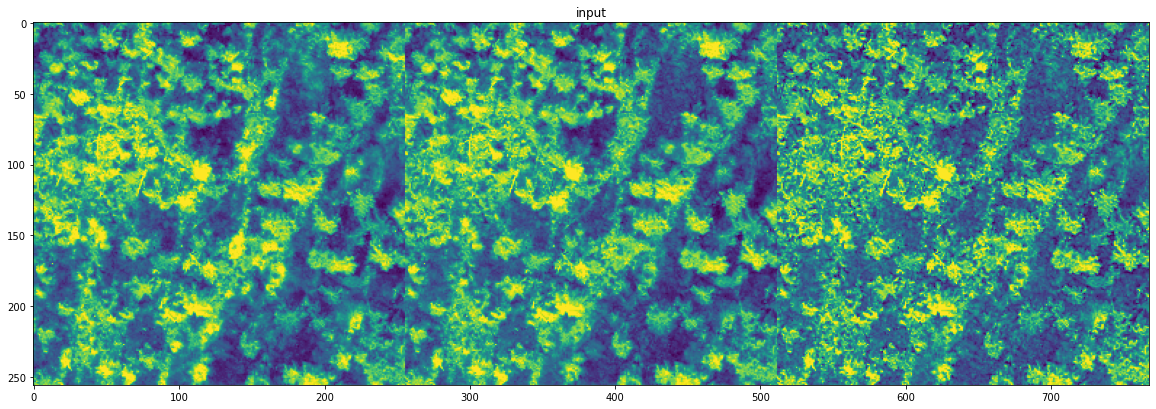

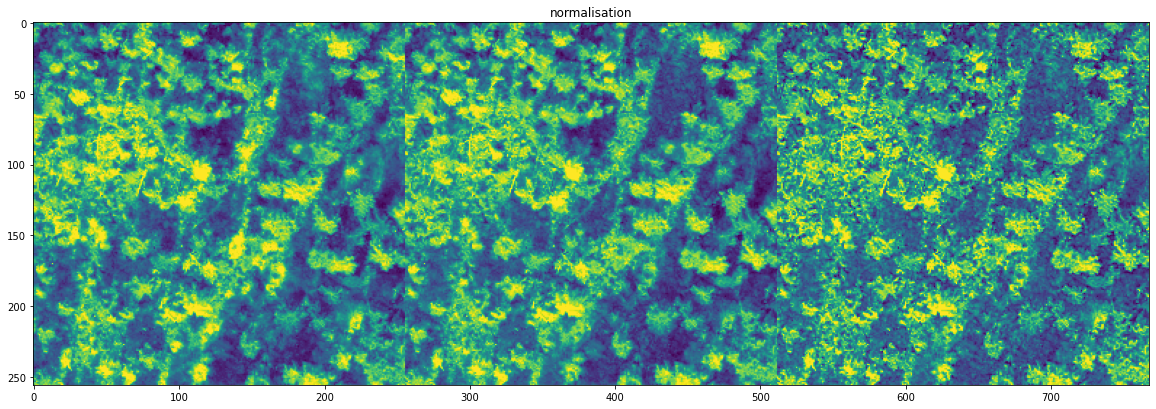

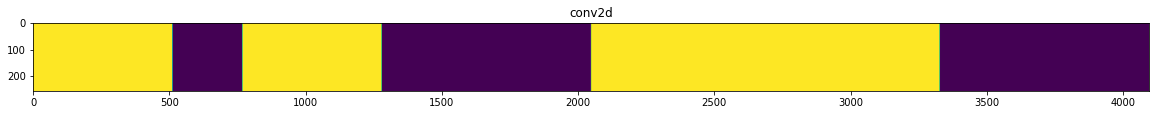

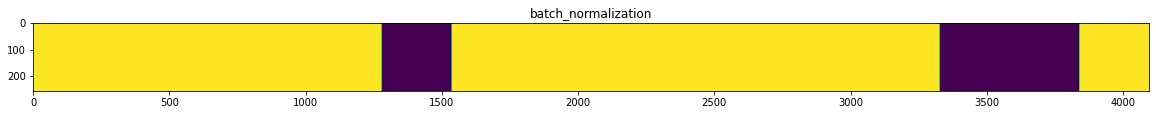

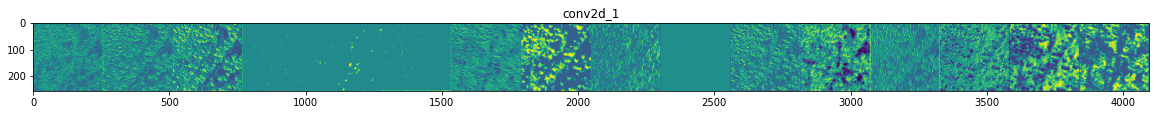

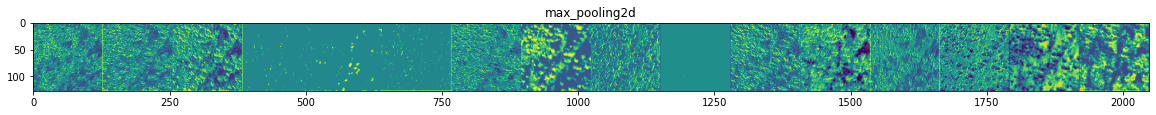

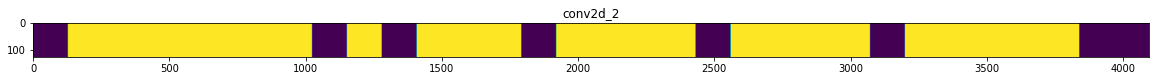

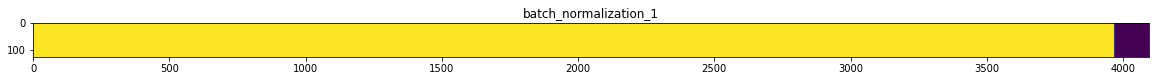

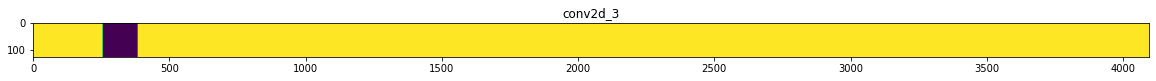

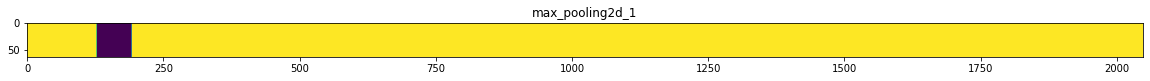

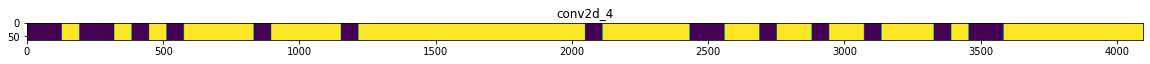

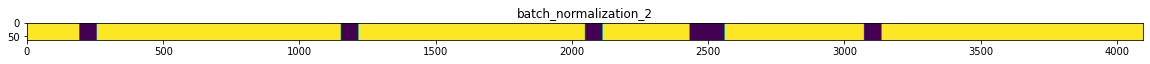

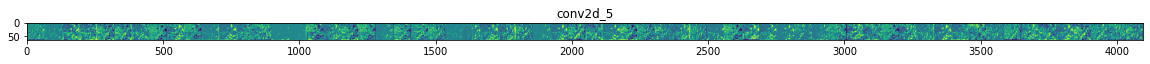

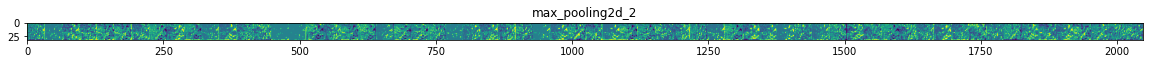

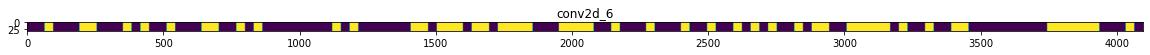

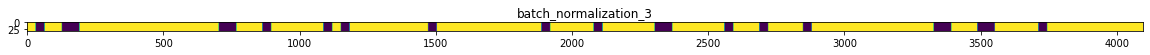

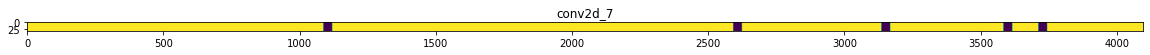

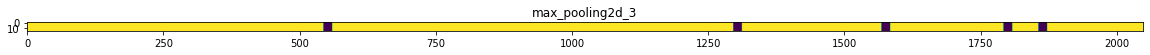

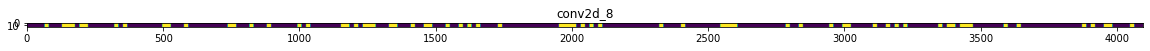

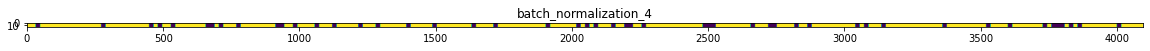

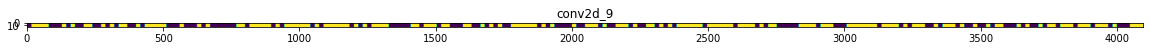

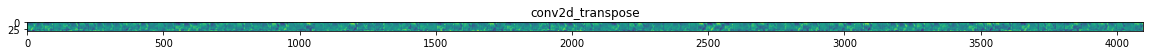

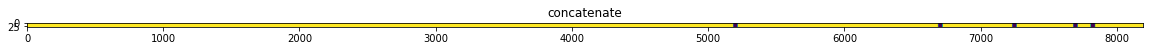

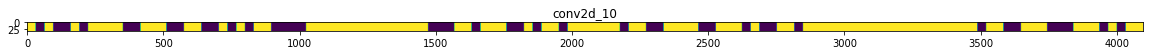

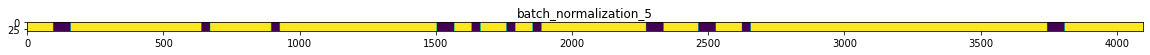

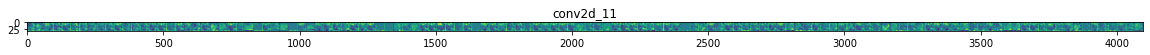

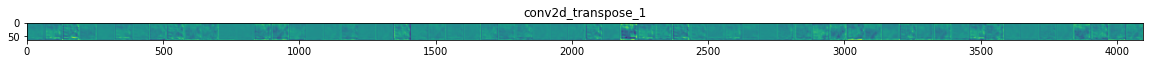

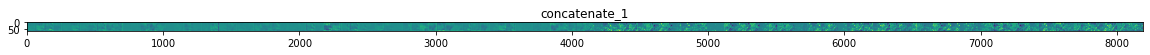

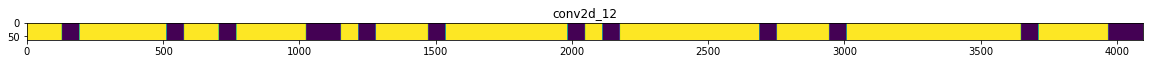

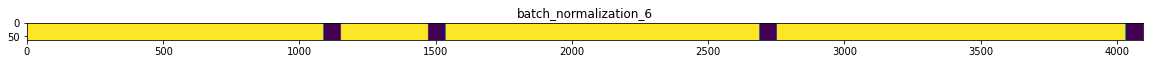

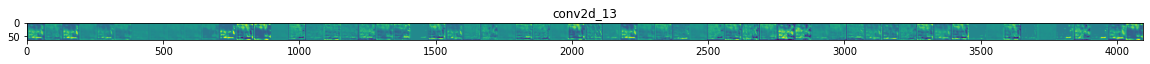

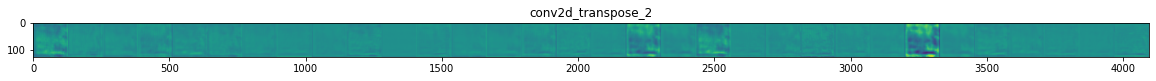

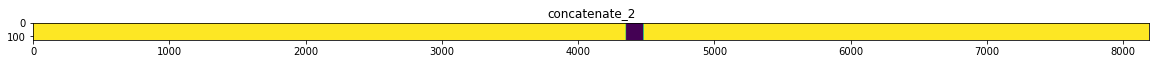

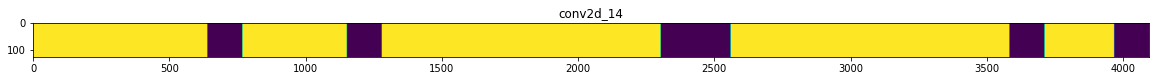

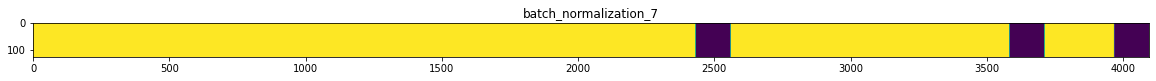

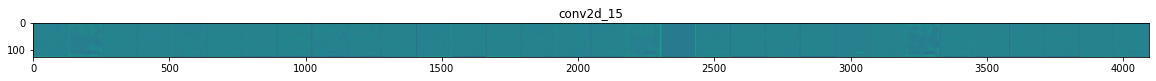

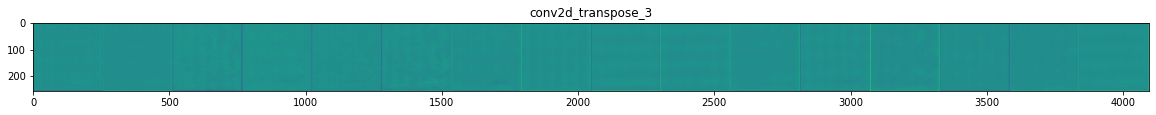

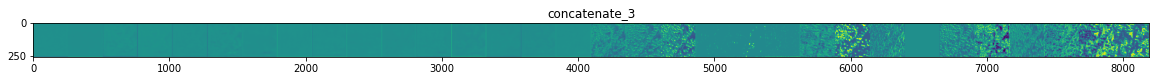

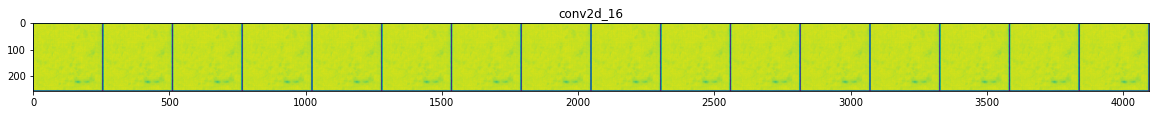

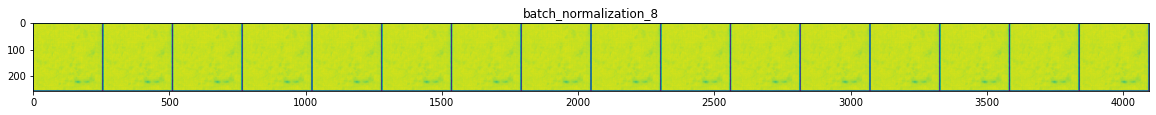

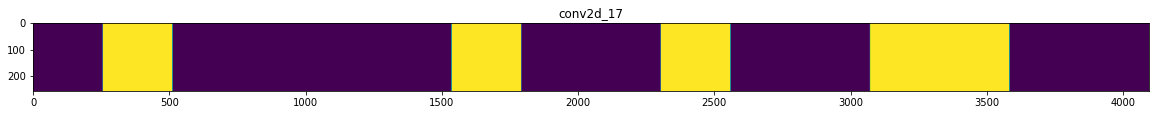

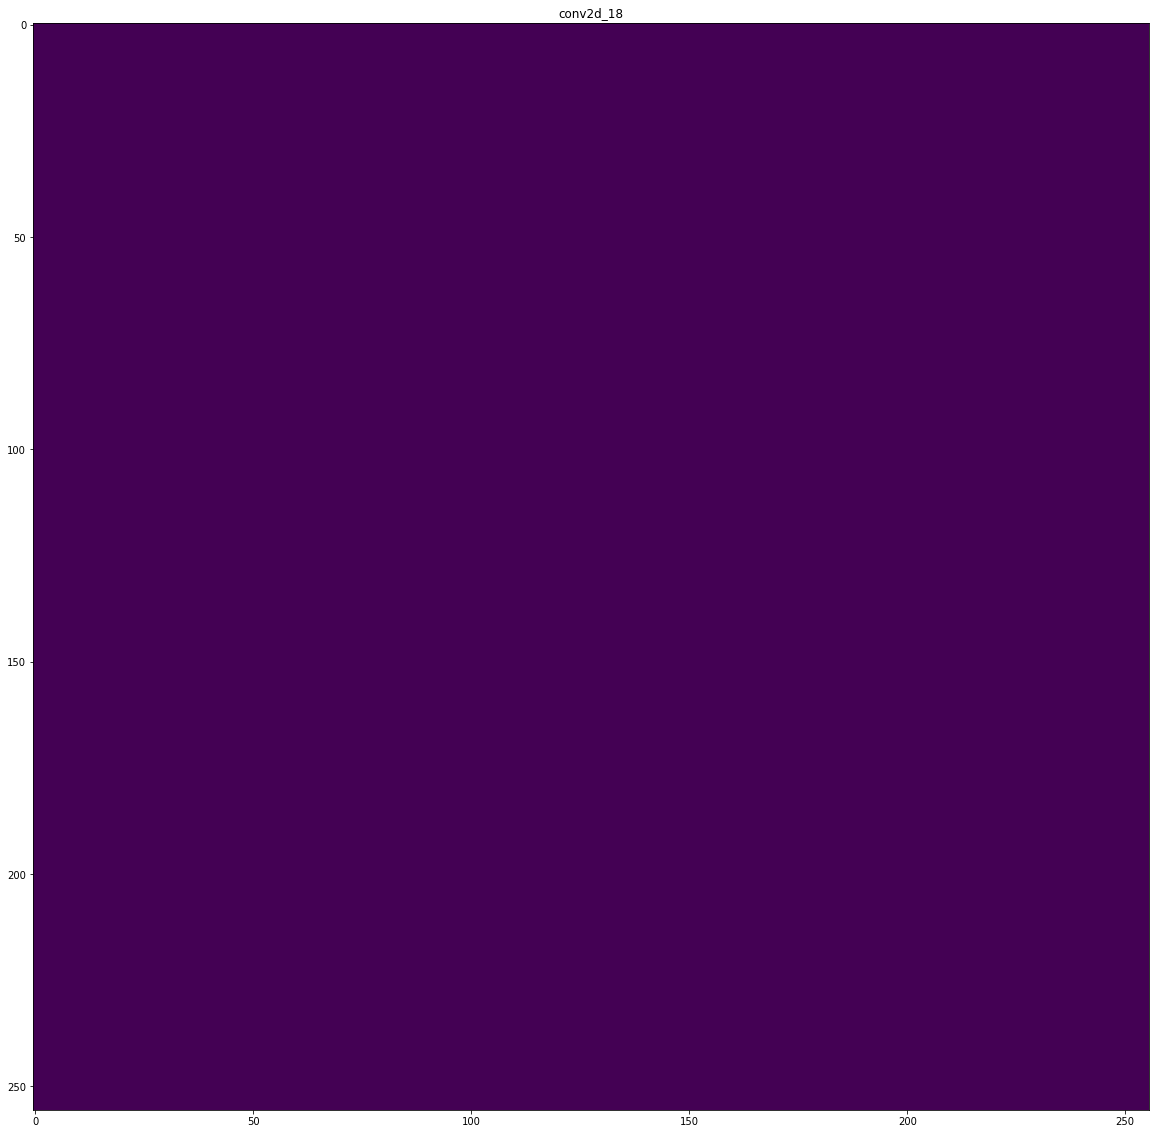

In [212]:
vis_cnn_feature_maps(model, image[1])

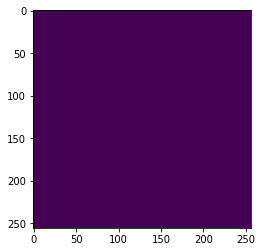

In [194]:
plt.imshow(model.predict(image)[0])